# Dev New Design Matrix Generator (DMG)

**Goal**: Use this notebook to develop a new, more flexible DMG class.

**Motivation**: The previous version has a "generate_base_matrix" function and then other classes operated on that base matrix (e.g. filtering the history). The structure of the base matrix was not flexible at all and required adding lots of if else logic. Also, adding violation features to a binary model was not possible Now that I am entering a phase of wanting to change features readily, this needs to be updated.

In [30]:
import pandas as pd
import numpy as np
from multiglm.features.exp_filter import ExpFilter
from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *
from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression


from multiglm.data.dataset_loader import *

from multiglm.experiments.experiment import *
from multiglm.experiments.experiment_sigma_sweep import ExperimentSigmaSweep
from multiglm.experiments.experiment_tau_sweep import ExperimentTauSweep

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df = DatasetLoader(animal_ids=["W051"], data_type="new_trained").load_data()

Loading data for animal ids:  ['W051']


## Taus

### Fetching Fit Taus

In [37]:
get_animals_tau(df, "prev_violation")

2.0

In [50]:
filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))

0        0.000000
1        0.396139
2        0.636409
3        0.782140
4        0.474392
           ...   
98918    0.024123
98919    0.011962
98920    0.007256
98921    0.400539
98922    0.240270
Name: prev_viol_exp, Length: 98923, dtype: float64

### Tau Sweep


In [76]:
tau_config = {
    "session": lambda df: (copy(df.session)),
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "voil_exp_filt2": lambda df: (exp_filter_column(df.violation, df.session, tau=1)),
    "tau_sweep": {
        "taus": [1, 2, 3],
        "col_name": "violation_exp_filt",
        "col_func": lambda df: (copy(df.violation)),
        "current_idx": 0,
    },
    "labels": {"column_name": "choice"},
}

dmg = DesignMatrixGeneratorPWM(df, tau_config)
X, y = dmg.create()




 !!!!!!implementing tau sweep with 1





In [77]:
X.voil_exp_filt2.equals(X.violation_exp_filt)

True

Good- this passes the first test of implementing the filter in static form through either a "tau_sweep" call or a normal call to the function. Now we must update the ExperimentTauSweep so that it 

1) runs with new DMG and 
2) does the iterating.

### Tesing with Experiment Tau Sweep

In [88]:
tau_config = {
    "session": lambda df: (copy(df.session)),
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "tau_sweep": {
        "taus": [1, 2, 3],
        "col_name": "violation_exp_filt",
        "col_func": lambda df: (prev_violation(df)),
        "current_idx": 0,
    },
    "labels": {"column_name": "choice"},
}

models_config = {
    "example_model_name": {
        "model_class": MultiClassLogisticRegression,
        "dmg_config": tau_config,
    }
}


params = {
    "animals": ["W051", "W065"],
    "data_type": "new_trained",
    "sigmas": [0.07, 0.13],  # , 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "eval_train": True,
    "model_config": models_config,
}

In [89]:
experiment = ExperimentTauSweep(params)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W065']


In [90]:
experiment.run()


 >>>> evaluating animal W051 sweeping taus of XXX <<<<



 !!!!!!implementing tau sweep with 1




 ***** evaluating tau 1, sigma 0.07 *****
         Current function value: 65248.964552
         Iterations: 19
         Function evaluations: 79
         Gradient evaluations: 68

 ***** evaluating tau 1, sigma 0.13 *****
         Current function value: 64990.630444
         Iterations: 20
         Function evaluations: 76
         Gradient evaluations: 64



 !!!!!!implementing tau sweep with 2




 ***** evaluating tau 2, sigma 0.07 *****
Optimization terminated successfully.
         Current function value: 65246.130024
         Iterations: 21
         Function evaluations: 31
         Gradient evaluations: 31

 ***** evaluating tau 2, sigma 0.13 *****
         Current function value: 64964.545443
         Iterations: 18
         Function evaluations: 27
         Gradient evaluations: 27



 !!!!!!implementing tau sweep with 3




 ***** evaluating tau 3, sigma 0.07 *****
         C

In [98]:
from multiglm.visualizations.model_visualizer import *

mvt = ModelVisualizerTauSweep(experiment)

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

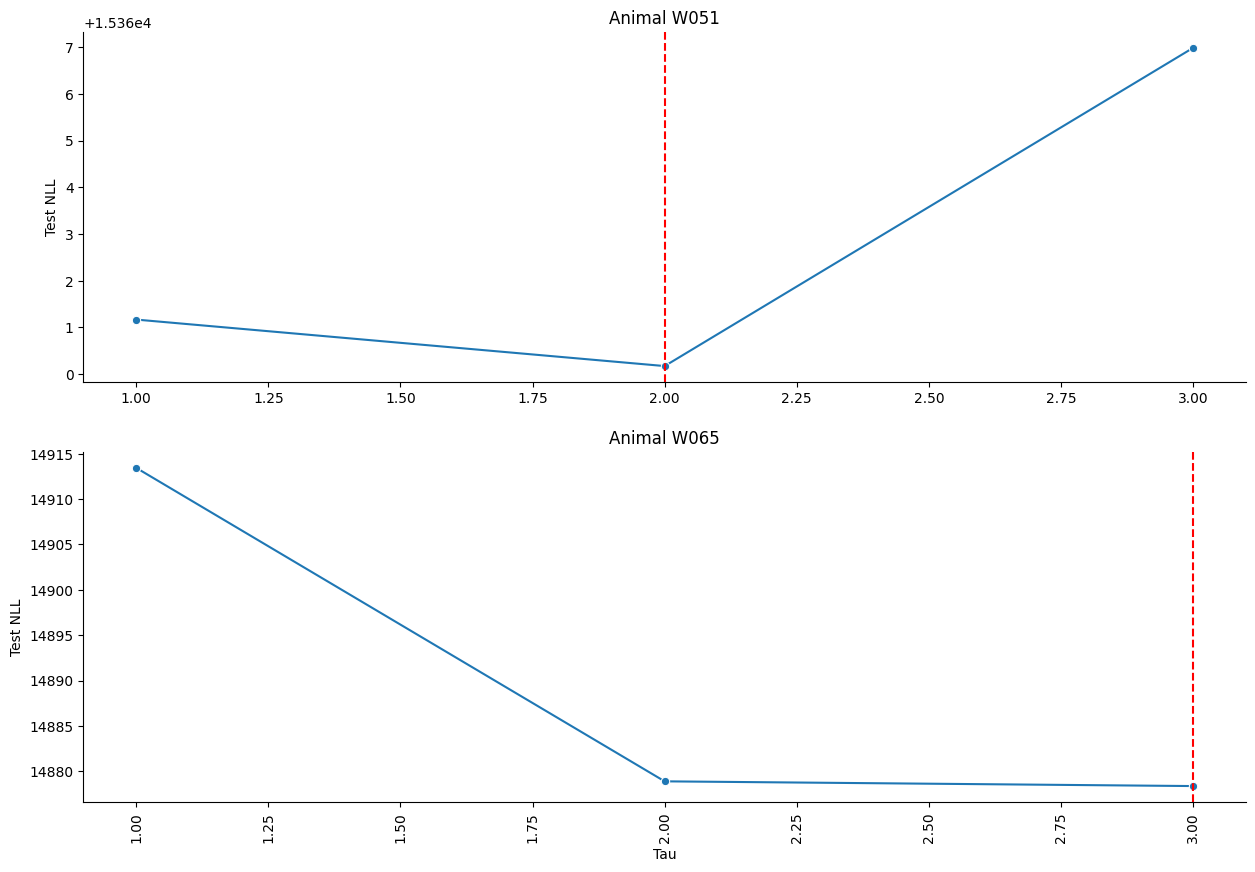

In [101]:
mvt.plot_nll_over_taus_by_animal()

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


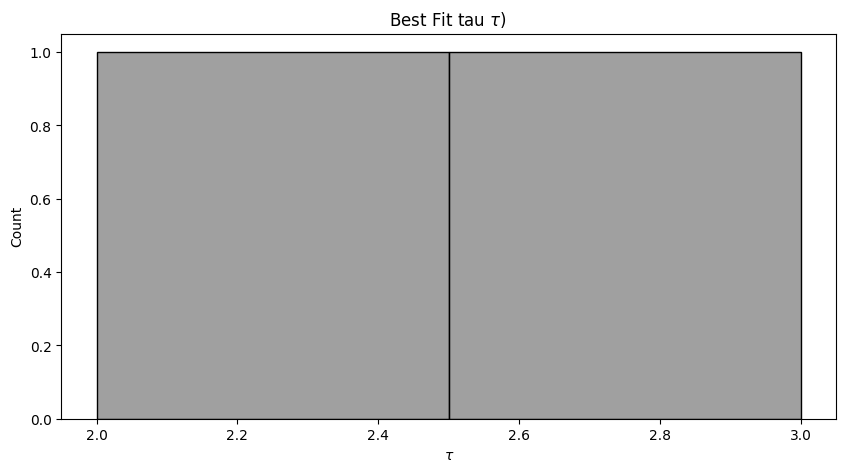

In [106]:
mvt.plot_tau_histogram("tau")

# TODO
- everything seems to be running, just need to clean up the code and make sure things are good
- run a full sweep over the prev violation tau and see if it works/compare solved taus
- check tau saves out properly in fit models
- remove df from save

- deal with model compare

## Testing with Experiment Sigma Sweep

Want to see if the new DMG config and generation works with the experiment and experiment sigma sweep classes. Moreover, want to see if the weights seem reasonable.


In [20]:
dmg_config = {
    "session": lambda df: (copy(df.session)),
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
    "prev_correct": lambda df: prev_correct_side(df),
    "prev_choice": lambda df: prev_choice(df),
    "labels": {"column_name": "choice"},
}

models_config = {
    "example_model_name": {
        "model_class": MultiClassLogisticRegression,
        "dmg_config": dmg_config,
    }
}

params = {
    "animals": None,  # all animals
    "data_type": "new_trained",
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "eval_train": True,
    "tau_columns": None,
    "model_config": models_config,
}

In [23]:
experiment = ExperimentSigmaSweep(params)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


In [24]:
experiment.run()


 >>>> evaluating animal W051 <<<<

 ***** evaluating model example_model_name w/ sigma 0.07 *****
         Current function value: 64995.381251
         Iterations: 25
         Function evaluations: 116
         Gradient evaluations: 103

 ***** evaluating model example_model_name w/ sigma 0.13 *****
         Current function value: 64759.621472
         Iterations: 25
         Function evaluations: 107
         Gradient evaluations: 94

 ***** evaluating model example_model_name w/ sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 64687.335235
         Iterations: 24
         Function evaluations: 36
         Gradient evaluations: 36

 ***** evaluating model example_model_name w/ sigma 0.5 *****
         Current function value: 64667.068445
         Iterations: 22
         Function evaluations: 44
         Gradient evaluations: 39

 ***** evaluating model example_model_name w/ sigma 1 *****
Optimization terminated successfully.
         Current f

In [25]:
from multiglm.visualizations.model_visualizer import ModelVisualizer

mv = ModelVisualizer(experiment)

In [ ]:
mv.plot_sigma_summary()


/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/visualizations/model_visualizer.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_idx = self.fit_models.groupby("animal_id")[col_name].idxmin()
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


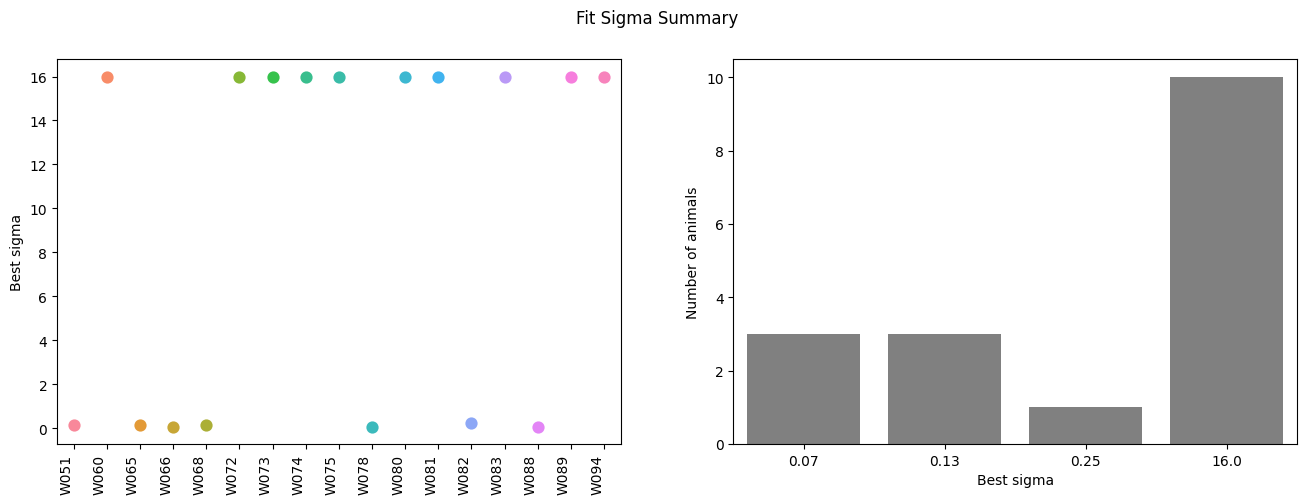

In [33]:
mv.plot_sigma_summary()

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/visualizations/model_visualizer.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_idx = self.fit_models.groupby("animal_id")[col_name].idxmin()


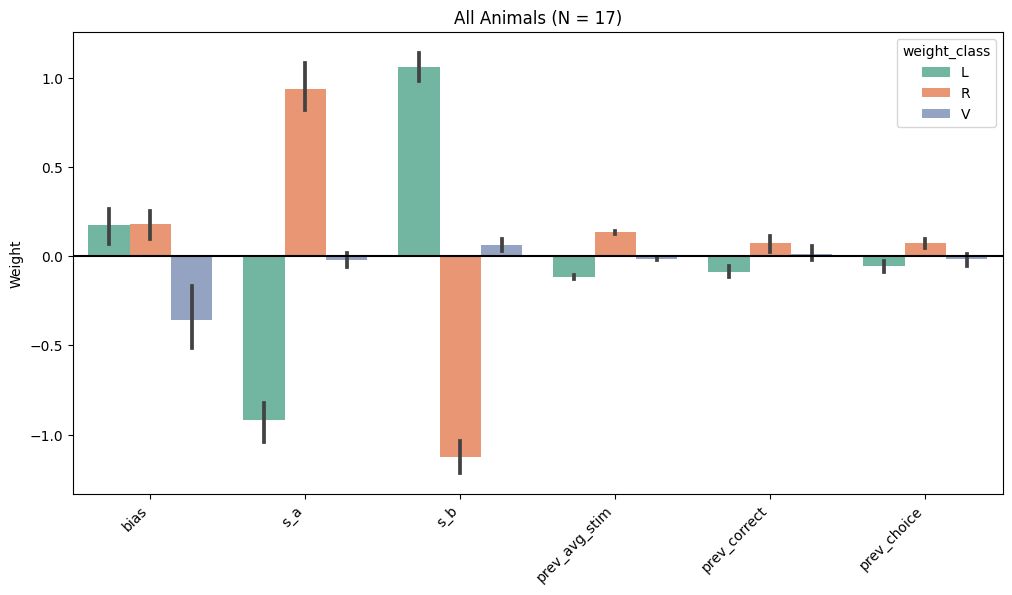

In [34]:
mv.plot_weights_summary(palette="Set2")

### Checking prev filter masking and PWM specific methods

In [196]:
dmg_config = {
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
    "labels": {"column_name": "choice"},
}

dmg = DesignMatrixGeneratorPWM(df, dmg_config, verbose=True)
X, y = dmg.create()

DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'prev_avg_stim'])
DMG: Creating labels with column: choice.
DMG: One hot encoding labels.


In [197]:
X.drop(columns=["choice"]).head()

,bias,s_a,s_b,prev_avg_stim
0,1,-1.649967,-0.834803,0.000000
1,1,-1.649967,-0.834803,-0.000000
2,1,0.019421,-0.834803,-0.000000
3,1,-0.815273,0.000556,-0.000000
4,1,0.854115,0.000556,-0.445713


In [200]:
y[0:5]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [164]:
config = {
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
    "prev_viol": lambda df: prev_violation(df),
    "prev_viol_exp": lambda df: filtered_prev_viol(df, tau=0.6),
    "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
    "prev_correct": lambda df: prev_correct_side(df),
    "prev_choice": lambda df: prev_choice(df),
    "labels": {"column_name": "choice"},
}

dmg = DesignMatrixGeneratorPWM(df, config, verbose=True)
X, y = dmg.create()

DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'prev_avg_stim', 'prev_viol', 'prev_viol_exp', 'prev_correct', 'prev_choice'])
DMG: Creating labels with column: choice.
DMG: One hot encoding labels.


In [163]:
X.head(15)

,choice,bias,s_a,s_b,prev_avg_stim,prev_viol_exp,prev_correct,prev_choice
0,2,1,-1.649967,-0.834803,0.000000,0.000000,0,0
1,2,1,-1.649967,-0.834803,-0.000000,0.811319,0,0
2,2,1,0.019421,-0.834803,-0.000000,0.964558,0,0
3,0,1,-0.815273,0.000556,-0.000000,0.993501,0,0
4,1,1,0.854115,0.000556,-0.445713,0.187648,-1,-1
5,2,1,-1.649967,-0.834803,0.467570,0.035442,1,1
6,1,1,0.019421,-0.834803,-0.000000,0.817819,0,0
7,1,1,0.854115,0.000556,-0.445713,0.154271,1,1
8,1,1,-1.649967,-0.834803,0.467570,0.028943,1,1
9,0,1,0.019421,0.835916,-1.358996,0.005467,-1,1


In [125]:
dd = DesignMatrixGeneratorPWM(df, config, verbose=True)

dd.verbose

True

### Labels

In [38]:

config_labels = {"column_name": "choice", "mapping": {0: 0, 1: 1, 2: 7}}

In [39]:
labels_col = df[config_labels["column_name"]]

if "mapping" in config_labels.keys():
    labels_col = remap_values(labels_col, config_labels["mapping"])

In [41]:
labels_col = labels_col.dropna().astype(int)

In [44]:
pd.get_dummies(labels_col).to_numpy(copy=True)

array([[False, False,  True],
       [False, False,  True],
       [False, False,  True],
       ...,
       [False, False,  True],
       [False,  True, False],
       [ True, False, False]])

### Exp Filter

In [4]:
from multiglm.features.exp_filter import ExpFilter

""" 
Testing filter is the exact same for both the class directly and the function
"""

filt = ExpFilter(tau=4, column="violation", verbose=False).apply_filter_to_dataframe(df)
(filt["violation_exp"] == exp_filter_column(df["violation"], df.session, tau=4)).all()

True

In [65]:
(filt["violation_exp"] == exp_filter_column(df["violation"], df.session, tau=4)).all()

True

### Assorted Funcs

In [20]:
remap_values(df.choice, {0: -1, 2: 0}), 

0        0
1        0
2        0
3       -1
4        1
        ..
98918    1
98919    1
98920    0
98921    1
98922   -1
Name: choice, Length: 98923, dtype: int64

In [27]:
shift_n_trials_up(df.violation, df.session, shift_size=2)

0        0.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
98918    0.0
98919    0.0
98920    0.0
98921    0.0
98922    1.0
Length: 98923, dtype: float64

In [74]:
df.violation.unique()

array([1, 0])

In [79]:
"s_a" in config.keys()

False

### Shift size & Session Masking

In [25]:
"""Testing a shift size > n trials in a session """

session_ids = [1] * 10 + [2] * 3 + [3] * 8

# Create the Series
sessions = pd.Series(session_ids)

mask = get_session_start_mask(sessions, shift_size=7)

for i in range(len(mask)):
    print(mask[i], sessions[i])

False 1
False 1
False 1
False 1
False 1
False 1
False 1
True 1
True 1
True 1
False 2
False 2
False 2
False 3
False 3
False 3
False 3
False 3
False 3
False 3
True 3


In [69]:
get_prev_event_mask(df.violation, df.session)

0         True
1        False
2        False
3        False
4         True
         ...  
98918     True
98919     True
98920     True
98921    False
98922     True
Length: 98923, dtype: bool

In [19]:
config = {
    "s_a_shifted": lambda bb: (
        mask_prev_event(
            shift_n_trials_up(
                bb["s_a"],
                bb.session,
                shift_size=1,
            ),
            bb.violation,
            bb.session,
        )
    )
}

dmg = DesignMatrixGeneratorPWM(df, config)
dmg.create()

No labels found in config, only creating data matrix.


,choice,s_a_shifted
0,2,0.0
1,2,0.0
2,2,0.0
3,0,0.0
4,1,68.0
...,...,...
98918,1,76.0
98919,1,91.0
98920,2,60.0
98921,1,0.0


Next steps:

1. base label class
2. PWM specific data fxs
3. PWM specific label fxs